<a href="https://colab.research.google.com/github/anthonymirandag/IndoorLocalization/blob/master/IndoorLacalizationCNN2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
!pip install tensorflow-gpu==2.0.0.alpha0
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.utils import shuffle
#!pip install pyts
#from pyts.image import GramianAngularField

## Carga de datos


In [0]:
#path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/movil/Tx_0x01.csv'
path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/Tx_0x02.csv'
df = pd.read_csv(path_data)

In [0]:
#i_serie  = 0
target_label = 'Sector'
tam_slices = 20

## Utils Funciones

In [0]:
def scale_serie_minmax(serie):
  #serie = serie.reshape(-1, 1)
  scaler = MinMaxScaler(feature_range = (-1,1))
  scaler.fit(serie)
  serie_1 = scaler.transform(serie)
  return serie_1

In [0]:
def imaging_time_series_GAF(serie):
  # convert to polar
  n = len(serie)
  serie = serie.reshape(-1, 1)
  ones = np.ones((1,n))
  x = serie.dot(ones)
  y = ones.transpose().dot(serie.transpose())
  GAF = x*y - (np.sqrt(np.absolute(1.0-np.power(x,2)))*np.sqrt(np.absolute(1.0-np.power(y,2))))
  return GAF 

In [0]:
def multi_serie_to_image(series):
   n,n_var = series.shape
   x_image = np.zeros((n,n,n_var))
   for i in range(n_var):
     serie = series[:,i]
     #serie = scale_serie_minmax(serie)
     image = imaging_time_series_GAF(serie)
     x_image[:,:,i] = image
   return x_image  

In [0]:
def reshape_to_matrix_rssi(x_sector,size):
  total_sample ,n = x_sector.shape
  residual_elem = total_sample % size
  return x_sector[0:total_sample-residual_elem,:].reshape(-1,size,n)


In [0]:
def train_test_split_rssi(df, test_size= 0.1, random_state=27, tam_slices =20):
  x =  df.drop(target_label, axis= 1).values
  y = df[target_label].values
  labelencoder_y = LabelEncoder()
  y = labelencoder_y.fit_transform(y)  
  _, countsTotal = np.unique(y, return_counts=True)
  n = x.shape[0]
  data_shape = x.shape[1:]
  n_rand = math.floor(np.floor(countsTotal/tam_slices).sum() * 0.1)
  print(n_rand)
  np.random.seed(random_state)
  n_lables = np.unique(y).shape
  rand_labels = np.random.randint(n_lables, size=n_rand)
  unique, counts = np.unique(rand_labels, return_counts=True)
  x_train = np.array([])
  x_test = np.array([])
  y_train = np.array([])  
  y_test = np.array([])
  print(unique)
  print(counts)
  for index, label in enumerate(unique):
    print('index',index)
    print('label',label)
    tam_block = counts[index]*tam_slices
    tam_total = y[y == label].shape[0]
    print('tam_total',tam_total)
    print('tam_block',tam_block)
    init_block = np.random.randint(tam_total-tam_block,size=1)[0] 
    print('init_block',init_block)
    x_sector = x[y == label,:]
    x_sector = scale_serie_minmax(x_sector)
    map_split = [[0,init_block],[init_block+tam_block,tam_total]]
    series_sector = np.array([])
    for split in map_split:
      print('split',split)
      for i in range(tam_slices):
        if(split[0]==0 and i== 0 and label == 0 ):
          series_sector = reshape_to_matrix_rssi(x_sector[0:split[1],:], tam_slices)
          x_train =  series_sector
          y_train = np.ones(series_sector.shape[0])*label 
        else:
          series_sector = reshape_to_matrix_rssi(x_sector[split[0]+i:split[1],:],tam_slices)
          x_train = np.concatenate((x_train, series_sector))
          y_train = np.concatenate((y_train,np.ones(series_sector.shape[0])*label))
    if(label == 0):
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = block_sector
      y_test = np.ones(block_sector.shape[0])*label       
    else:
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = np.concatenate((x_test,block_sector))
      y_test = np.concatenate((y_test,np.ones(block_sector.shape[0])*label))
  x_train,y_train = shuffle(x_train,y_train)
  x_test,y_test = shuffle(x_test,y_test)

  return x_train, x_test, y_train, y_test

In [0]:
# not used
''' def train_test_split_rssi(df, test_size= 0.1, random_state=27, tam_slices =20):
  x =  df.drop(target_label, axis= 1).values
  y = df[target_label].values
  labelencoder_y = LabelEncoder()
  y = labelencoder_y.fit_transform(y)  
  _, countsTotal = np.unique(y, return_counts=True)
  n = x.shape[0]
  data_shape = x.shape[1:]
  n_rand = math.floor(np.floor(countsTotal/tam_slices).sum() * 0.1)
  print(n_rand)
  np.random.seed(random_state)
  n_lables = np.unique(y).shape
  rand_labels = np.random.randint(n_lables, size=n_rand)
  unique, counts = np.unique(rand_labels, return_counts=True)
  x_train = np.array([])
  x_test = np.array([])
  y_train = np.array([])  
  y_test = np.array([])
  print(unique)
  print(counts)
  for index, label in enumerate(unique):
    print('index',index)
    print('label',label)
    tam_block = counts[index]*tam_slices
    tam_total = y[y == label].shape[0]
    print('tam_total',tam_total)
    print('tam_block',tam_block)
    init_block = np.random.randint(tam_total-tam_block,size=1)[0] 
    print('init_block',init_block)
    x_sector = x[y == label,:]
    map_split = [[0,init_block],[init_block+tam_block,tam_total]]
    series_sector = np.array([])
    for split in map_split:
      print('split',split)
      for i in range(tam_slices):
        if(split[0]==0 and i== 0 and label == 0 ):
          series_sector = reshape_to_matrix_rssi(x_sector[0:split[1],:], tam_slices)
          x_train =  series_sector
          y_train = np.ones(series_sector.shape[0])*label 
        else:
          series_sector = reshape_to_matrix_rssi(x_sector[split[0]+i:split[1],:],tam_slices)
          x_train = np.concatenate((x_train, series_sector))
          y_train = np.concatenate((y_train,np.ones(series_sector.shape[0])*label))
    if(label == 0):
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = block_sector
      y_test = np.ones(block_sector.shape[0])*label       
    else:
      block_sector = reshape_to_matrix_rssi(x_sector[init_block:init_block+tam_block,:],tam_slices)
      x_test = np.concatenate((x_test,block_sector))
      y_test = np.concatenate((y_test,np.ones(block_sector.shape[0])*label))
  x_train,y_train = shuffle(x_train,y_train)
  x_test,y_test = shuffle(x_test,y_test)
  return x_train, x_test, y_train, y_test '''

In [0]:
def transformer_gaf_multivariate(time_series,target_label,size = 20):
  n,tam_serie,n_var =time_series.shape
  images_time_series = np.zeros((n,size,size,n_var))
  for i in range(n):
    image = multi_serie_to_image(time_series[i,:,:])
    images_time_series[i,:,:,:] = image 
  return images_time_series

In [0]:
def generate_images_aug(df,target_label ,size = 20):
  # Escalado por sector
  dataset = df.copy()
  x_train, x_test, y_train, y_test = train_test_split_rssi(dataset,test_size= 0.1, random_state=27, tam_slices =tam_slices)
  x_train = transformer_gaf_multivariate(x_train,target_label,size)
  x_test = transformer_gaf_multivariate(x_test,target_label,size)
  return x_train, x_test, y_train, y_test

In [0]:
# not used
def generate_images(df,target_label ,size = 20):
  dataset = df.copy()
  sectors = dataset[target_label].unique()
  x_images = np.array([])
  y_labels = np.array([])
  '''   for sector  in sectors:
      df_sector = dataset[dataset.Sector == sector]
      x_sector =  df_sector.drop(target_label, axis= 1)
      columns = x_sector.columns
      x_sector = scale_serie_minmax(x_sector)
      dataset[columns][dataset.Sector == sector] = x_sector '''
  for sector  in sectors:
    df_sector = dataset[dataset.Sector == sector]
    #x_sector =  df_sector.drop(target_label, axis= 1).values
    x_sector =  df_sector.drop(target_label, axis= 1)
    total_sample ,n = x_sector.shape
    residual_elem = total_sample % size
    x_sector = scale_serie_minmax(x_sector)
    for i in range(size):
      if(i==0):
        series_sector = reshape_to_matrix_rssi(x_sector,size)
      else:
        series_sector = np.concatenate((series_sector,reshape_to_matrix_rssi(x_sector[i:,:],size) ))
    total_series = series_sector.shape[0]
    images_sector = np.zeros((total_series,size,size,n))
    for i in range(total_series):
      image = multi_serie_to_image(series_sector[i,:,:])
      #print(image)
      images_sector[i,:,:,:] = image  
    labels = np.ones(images_sector.shape[0])*sector 
    if sector == sectors[0]: 
      x_images = images_sector
      y_labels = labels.reshape(-1)
    else: 
      x_images = np.concatenate((x_images, images_sector))
      y_labels = np.concatenate((y_labels, labels.reshape(-1)))
  labelencoder_y = LabelEncoder()
  y_labels = labelencoder_y.fit_transform(y_labels)    
  return  x_images, y_labels    
   

In [0]:
# not used
def generate_images(dataset,target_label ,size = 20):
  sectors = dataset[target_label].unique()
  x_images = np.array([])
  y_labels = np.array([])
  for sector  in sectors:
    df_sector = dataset[dataset.Sector == sector]
    x_sector =  df_sector.drop(target_label, axis= 1).values
    total_sample ,n = x_sector.shape
    residual_elem = total_sample % size
    x_sector = scale_serie_minmax(x_sector)
    for i in range(size):
      if(i==0):
        series_sector = reshape_to_matrix_rssi(x_sector,size)
      else:
        series_sector = np.concatenate((series_sector,reshape_to_matrix_rssi(x_sector[i:,:],size) x_sector[0+i:total_sample+i-residual_elem,:].reshape(-1,size,n)))
    total_series = series_sector.shape[0]
    images_sector = np.zeros((total_series,size,size,n))
    for i in range(total_series):
      image = multi_serie_to_image(series_sector[i,:,:])
      #print(image)
      images_sector[i,:,:,:] = image  
    labels = np.ones(images_sector.shape[0])*sector 
    if sector == sectors[0]: 
      x_images = images_sector
      y_labels = labels.reshape(-1)
    else: 
      x_images = np.concatenate((x_images, images_sector))
      y_labels = np.concatenate((y_labels, labels.reshape(-1)))
  labelencoder_y = LabelEncoder()
  y_labels = labelencoder_y.fit_transform(y_labels)    
  return  x_images, y_labels    

SyntaxError: ignored

In [0]:
def transfrom_imaging_time_series(dataset,target_label ,size = 20):
  sectors = dataset[target_label].unique()
  x_images = np.array([])
  y_labels = np.array([])
  for sector  in sectors:
    df_sector = dataset[dataset.Sector == sector]
    x_sector =  df_sector.drop(target_label, axis= 1).values
    total_sample ,n = x_sector.shape
    residual_elem = total_sample % size
    x_sector = scale_serie_minmax(x_sector)
    #for i in range(n):
    #  x_sector[:,i] = scale_serie_minmax(x_sector[:,i]).reshape((-1))
    series_sector = x_sector[0:-residual_elem,:].reshape(-1,size,n)
    total_series = series_sector.shape[0]
    images_sector = np.zeros((total_series,size,size,n))
    for i in range(total_series):
      image = multi_serie_to_image(series_sector[i,:,:])
      #print(image)
      images_sector[i,:,:,:] = image  
    labels = np.ones(images_sector.shape[0])*sector 
    if sector == sectors[0]: 
      x_images = images_sector
      y_labels = labels.reshape(-1)
    else: 
      x_images = np.concatenate((x_images, images_sector))
      y_labels = np.concatenate((y_labels, labels.reshape(-1)))
  labelencoder_y = LabelEncoder()
  y_labels = labelencoder_y.fit_transform(y_labels)    
  return  x_images, y_labels

In [0]:
x_train, x_test, y_train, y_test = generate_images_aug(df,target_label = target_label,size = tam_slices)

27
[ 0  1  2  3  4  5  6  8  9 10 12 13 14]
[2 3 1 4 1 2 1 4 1 3 1 2 2]
index 0
label 0
tam_total 368
tam_block 40
init_block 259
split [0, 259]
split [299, 368]
index 1
label 1
tam_total 360
tam_block 60
init_block 218
split [0, 218]
split [278, 360]
index 2
label 2
tam_total 256
tam_block 20
init_block 118
split [0, 118]
split [138, 256]
index 3
label 3
tam_total 432
tam_block 80
init_block 204
split [0, 204]
split [284, 432]
index 4
label 4
tam_total 408
tam_block 20
init_block 318
split [0, 318]
split [338, 408]
index 5
label 5
tam_total 378
tam_block 40
init_block 327
split [0, 327]
split [367, 378]
index 6
label 6
tam_total 399
tam_block 20
init_block 93
split [0, 93]
split [113, 399]
index 7
label 8
tam_total 393
tam_block 80
init_block 295
split [0, 295]
split [375, 393]
index 8
label 9
tam_total 404
tam_block 20
init_block 187
split [0, 187]
split [207, 404]
index 9
label 10
tam_total 352
tam_block 60
init_block 53
split [0, 53]
split [113, 352]
index 10
label 12
tam_total 375

In [0]:
path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/Tx_0x07.csv'
df = pd.read_csv(path_data)

In [0]:
x_images ,  y_labels = transfrom_imaging_time_series(df,target_label = target_label,size = tam_slices)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_images,y_labels, test_size= 0.10, random_state=27)

In [0]:
x_train.shape

(234, 20, 20, 5)

## Modelo

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[tam_slices, tam_slices, 5]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=15, activation='softmax'))
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 20, 20, 64)        2944      
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_153 (Dropout)        (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_154 (Dropout)        (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 3200)            

In [0]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto',restore_best_weights=True)

In [0]:
history = model.fit(x_train, y_train, validation_split=0.10,callbacks=[monitor] ,batch_size=16, epochs=100 , verbose = 1)

Train on 210 samples, validate on 24 samples
Epoch 1/100
210/210 [==============================] - 0s 2ms/sample - loss: 2.5700 - sparse_categorical_accuracy: 0.1571 - val_loss: 2.4416 - val_sparse_categorical_accuracy: 0.2083
Epoch 2/100
210/210 [==============================] - 0s 422us/sample - loss: 2.2201 - sparse_categorical_accuracy: 0.2619 - val_loss: 2.1498 - val_sparse_categorical_accuracy: 0.2083
Epoch 3/100
210/210 [==============================] - 0s 354us/sample - loss: 2.1573 - sparse_categorical_accuracy: 0.2333 - val_loss: 2.0849 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/100
210/210 [==============================] - 0s 345us/sample - loss: 2.0519 - sparse_categorical_accuracy: 0.2857 - val_loss: 2.0310 - val_sparse_categorical_accuracy: 0.2917
Epoch 5/100
210/210 [==============================] - 0s 419us/sample - loss: 1.8930 - sparse_categorical_accuracy: 0.3619 - val_loss: 1.7880 - val_sparse_categorical_accuracy: 0.2917
Epoch 6/100
210/210 [===========

In [0]:
def visualzation_accuracy_loss_values_epochs(history):
  fig, axs = plt.subplots(1, 2,figsize=(15, 5))
  axs[0].plot(history.history['sparse_categorical_accuracy'])
  axs[0].plot(history.history['val_sparse_categorical_accuracy'])
  axs[0].set_title('Model accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper left')
  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper left')

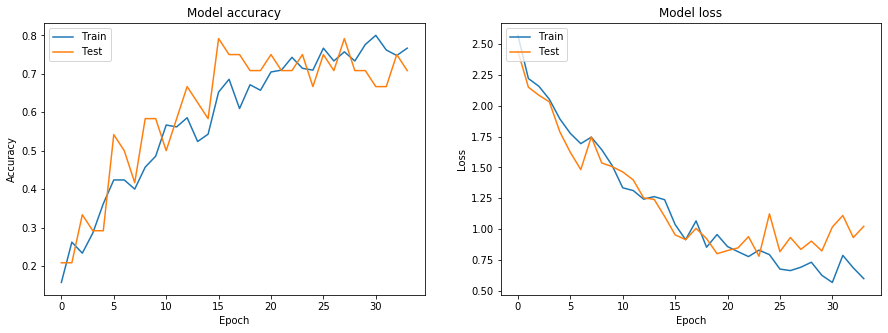

In [0]:
visualzation_accuracy_loss_values_epochs(history)

In [0]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))  

26/26 [==============================] - 0s 231us/sample - loss: 1.2086 - sparse_categorical_accuracy: 0.6923
Test accuracy: 0.692307710647583


In [0]:
x_test.shape

(34, 20, 20, 5)

In [0]:
x_test.shape

(81, 20, 20, 5)